# NYC Yellow Taxi Data Analysis

## 1. Setup
Initialize Spark session and import necessary libraries.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.types import StringType

In [5]:
spark = (
    SparkSession.builder
    .appName("NYC Yellow Taxi Data")
    .getOrCreate()
)

# Set legacy time parser policy to handle datetime patterns
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

## 2. Data Loading & Cleaning
Read parquet files and apply basic filtering.

In [6]:
df = spark.read.parquet("data/yellow_tripdata/yellow_tripdata_*.parquet")
df = (
    df
    .withColumn("tpep_pickup_datetime", F.to_timestamp("tpep_pickup_datetime"))
    .withColumn("tpep_dropoff_datetime", F.to_timestamp("tpep_dropoff_datetime"))
    .filter(F.col("tpep_pickup_datetime").between("2023-02-01", "2025-02-01"))
    .filter(F.col("trip_distance") > 0)
    .filter(F.col("total_amount") > 0)
)

df.count()

AnalysisException: [PATH_NOT_FOUND] Path does not exist: file:/home/jovyan/work/Big Data/data/yellow_tripdata/yellow_tripdata_*.parquet.

## 3. Feature Engineering
Create time-based and cost-per-minute features, and map day of week.

In [ ]:
def map_day_of_week(dow):
    days = {1: 'Sunday', 2: 'Monday', 3: 'Tuesday', 4: 'Wednesday',
            5: 'Thursday', 6: 'Friday', 7: 'Saturday'}
    return days.get(int(dow))

map_udf = F.udf(map_day_of_week, StringType())

df = (
    df
    .withColumn('pickup_hour', F.hour('tpep_pickup_datetime'))
    .withColumn('pickup_month', F.month('tpep_pickup_datetime'))
    .withColumn('trip_duration', F.unix_timestamp('tpep_dropoff_datetime') - F.unix_timestamp('tpep_pickup_datetime'))
    .withColumn('total_amount_per_minute', F.col('total_amount') / (F.col('trip_duration') / 60))
    .withColumn('pickup_day_of_week', F.date_format('tpep_pickup_datetime', 'u'))
    .withColumn('pickup_day_of_week_str', map_udf('pickup_day_of_week'))
)

## 4. Exploratory Data Analysis

In [ ]:
# Check for missing values
df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+-----------+------------+-------------+-----------------------+------------------+----------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|pickup_hour|pickup_month|trip_duration|total_amount_per_minute|pickup_day_of_week|pickup_day_of_week_str|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+-----------

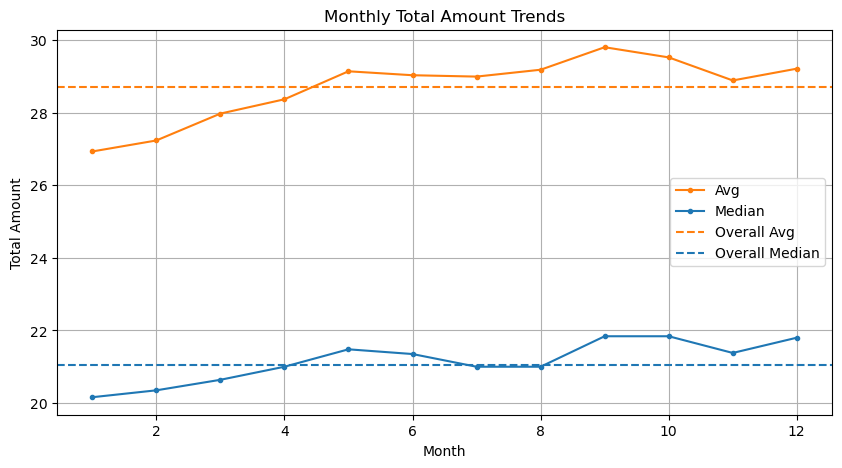

In [ ]:
# Monthly total amount trends
df_month = (
    df.groupBy("pickup_month")
      .agg(
          F.avg("total_amount").alias("avg_total_amount"),
          F.expr("percentile_approx(total_amount, 0.5)").alias("median_total_amount")
      )
      .orderBy("pickup_month")
)


overall_avg, overall_med = df.agg(F.avg('total_amount'), F.expr('percentile_approx(total_amount, 0.5)')).first()
pdf = df_month.toPandas()
plt.figure(figsize=(10,5))
plt.plot(pdf['pickup_month'], pdf['avg_total_amount'], color='tab:orange', marker='.', label='Avg')
plt.plot(pdf['pickup_month'], pdf['median_total_amount'], color='tab:blue', marker='.', label='Median')
plt.axhline(overall_avg, linestyle='--', color='tab:orange', label='Overall Avg')
plt.axhline(overall_med, linestyle='--', color='tab:blue', label='Overall Median')
plt.xlabel('Month')
plt.ylabel('Total Amount')
plt.title('Monthly Total Amount Trends')
plt.legend()
plt.grid()
plt.show()

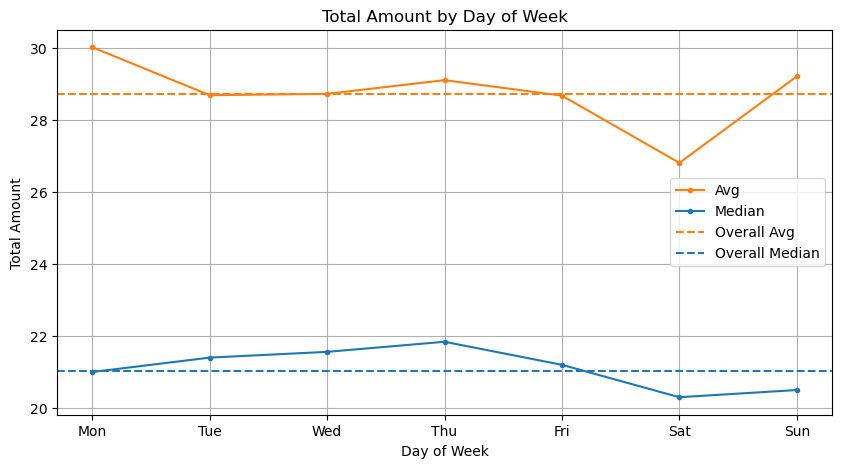

In [ ]:
# Average and median by day of week (1=Monday, 7=Sunday)
df_dow = (
    df.groupBy("pickup_day_of_week")
      .agg(
          F.avg("total_amount").alias("avg_total_amount"),
          F.expr("percentile_approx(total_amount, 0.5)").alias("median_total_amount")
      )
      .orderBy("pickup_day_of_week")
)

overall_avg, overall_med = df.agg(
    F.avg('total_amount'), 
    F.expr('percentile_approx(total_amount, 0.5)')
).first()

# Convert to pandas for plotting
pdf_dow = df_dow.toPandas()
pdf_dow["pickup_day_of_week"] = pdf_dow["pickup_day_of_week"].astype(int)
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
pdf_dow["day_name"] = pdf_dow["pickup_day_of_week"].map(lambda x: day_names[x - 1])

# Plot
plt.figure(figsize=(10,5))
plt.plot(pdf_dow['day_name'], pdf_dow['avg_total_amount'], color='tab:orange', marker='.', label='Avg')
plt.plot(pdf_dow['day_name'], pdf_dow['median_total_amount'], color='tab:blue', marker='.', label='Median')
plt.axhline(overall_avg, linestyle='--', color='tab:orange', label='Overall Avg')
plt.axhline(overall_med, linestyle='--', color='tab:blue', label='Overall Median')
plt.xlabel('Day of Week')
plt.ylabel('Total Amount')
plt.title('Total Amount by Day of Week')
plt.legend()
plt.grid()
plt.show()


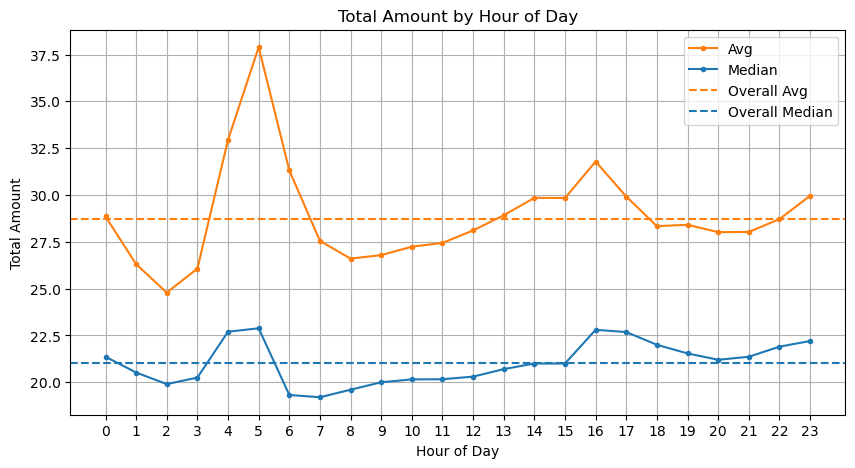

In [ ]:
# Average and median by pickup hour
df_hour = (
    df.groupBy("pickup_hour")
      .agg(
          F.avg("total_amount").alias("avg_total_amount"),
          F.expr("percentile_approx(total_amount, 0.5)").alias("median_total_amount")
      )
      .orderBy("pickup_hour")
)

overall_avg, overall_med = df.agg(
    F.avg('total_amount'), 
    F.expr('percentile_approx(total_amount, 0.5)')
).first()

pdf_hour = df_hour.toPandas()

# Plot
plt.figure(figsize=(10,5))
plt.plot(pdf_hour['pickup_hour'], pdf_hour['avg_total_amount'], color='tab:orange', marker='.', label='Avg')
plt.plot(pdf_hour['pickup_hour'], pdf_hour['median_total_amount'], color='tab:blue', marker='.', label='Median')
plt.axhline(overall_avg, linestyle='--', color='tab:orange', label='Overall Avg')
plt.axhline(overall_med, linestyle='--', color='tab:blue', label='Overall Median')
plt.xticks(np.arange(0, 24, 1))
plt.xlabel('Hour of Day')
plt.ylabel('Total Amount')
plt.title('Total Amount by Hour of Day')
plt.legend()
plt.grid()
plt.show()


## 5. Modeling
### 5.1 Linear Regression

In [ ]:
# Feature selection and pipeline setup
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

feature_cols = ['PULocationID', 'DOLocationID', 'pickup_hour', 'pickup_month', 'pickup_day_of_week']
indexers = [StringIndexer(inputCol=c, outputCol=f'{c}_idx') for c in ['PULocationID', 'DOLocationID', 'pickup_day_of_week']]
encoders = [OneHotEncoder(inputCol=f'{c}_idx', outputCol=f'{c}_ohe') for c in ['PULocationID', 'DOLocationID', 'pickup_day_of_week']]
assembler = VectorAssembler(
    inputCols=[f'{c}_ohe' for c in ['PULocationID', 'DOLocationID', 'pickup_day_of_week']] + ['pickup_hour', 'pickup_month'],
    outputCol='features'
)
lr = LinearRegression(labelCol='total_amount')

# Train-test split
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

# Build and fit
pipeline = Pipeline(stages=indexers + encoders + [assembler, lr])
model = pipeline.fit(train_df)
predictions = model.transform(test_df)

# Evaluate
evaluator = RegressionEvaluator(labelCol='total_amount', predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(predictions)
r2 = evaluator.evaluate(predictions, {evaluator.metricName: 'r2'})
print(f'Linear Regression RMSE: {rmse:.4f}, R2: {r2:.4f}')

### 5.2 Random Forest with Cross-Validation

In [ ]:
# Random Forest pipeline setup with CV
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

rf = RandomForestRegressor(labelCol='total_amount', featuresCol='features')
paramGrid = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [5, 10]) \
    .addGrid(rf.numTrees, [20, 50]) \
    .build()

cv = CrossValidator(
    estimator=Pipeline(stages=indexers + encoders + [assembler, rf]),
    estimatorParamMaps=paramGrid,
    evaluator=RegressionEvaluator(labelCol='total_amount', predictionCol='prediction', metricName='rmse'),
    numFolds=3
)
cvModel = cv.fit(train_df)
bestModel = cvModel.bestModel
bestPredictions = bestModel.transform(test_df)

rmse_rf = evaluator.evaluate(bestPredictions)
r2_rf = evaluator.evaluate(bestPredictions, {evaluator.metricName: 'r2'})
print(f'Random Forest RMSE: {rmse_rf:.4f}, R2: {r2_rf:.4f}')